In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob
import PIL
from sklearn.metrics import confusion_matrix
import keras
# from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [27]:
import cv2

import PIL
from PIL import Image as img

In [28]:
metadata = pd.read_csv("./Dataset/HAM10000_metadata.csv")
metadata = metadata[['image_id', 'dx']].rename({'image_id':'imgid' , 'dx' :'class'})

In [29]:
metadata.rename({'image_id': 'image_id', 'dx': 'class'}, axis=1, inplace=True)
metadata.head()

,image_id,class
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [30]:
metadata['class'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: class, dtype: int64

In [31]:
le = LabelEncoder()
metadata['class'] = le.fit_transform(metadata['class'])

In [32]:
df1 = metadata[metadata['class']==0]
df2 = metadata[metadata['class']==1]
df3 = metadata[metadata['class']==2]
df4 = metadata[metadata['class']==3]
df5 = metadata[metadata['class']==4]
df6 = metadata[metadata['class']==5]
df7 = metadata[metadata['class']==6]

In [33]:
samples = 200
df1_balanced = resample(df1,replace = True,n_samples = samples,random_state = 2)
df2_balanced = resample(df2,replace = True,n_samples = samples,random_state = 2)
df3_balanced = resample(df3,replace = True,n_samples = samples,random_state = 2)
df4_balanced = resample(df4,replace = True,n_samples = samples,random_state = 2)
df5_balanced = resample(df5,replace = True,n_samples = samples,random_state = 2)
df6_balanced = resample(df6,replace = True,n_samples = samples,random_state = 2)
df7_balanced = resample(df7,replace = True,n_samples = samples,random_state = 2)

In [34]:
merged = pd.concat([df1_balanced,df2_balanced,df3_balanced,
                  df4_balanced,df5_balanced,df6_balanced,df7_balanced])

In [35]:
dir = "./Dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}
merged['path'] = merged['image_id'].map(image_path.get)

In [36]:
merged.head(1)

,image_id,class,path
9855,ISIC_0029851,0,./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851...


In [37]:
sample = {}
numpy_horizontal = []
limit = 0
for index, row in merged.iterrows():
    limit +=1
    if limit==10:
        break
    pth =row['path']
    cl = row['class']
    print(pth)
    image = np.asarray(img.open(pth).resize((224,224)))
    
#     print(image.shape)
    if len(numpy_horizontal)==0:
        numpy_horizontal = np.hstack((image, image))
    
    else:
        numpy_horizontal = np.hstack((numpy_horizontal, image))


./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0027795.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030827.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030242.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028517.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0026729.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028763.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0032356.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0029860.jpg


(100, 1000, 3)


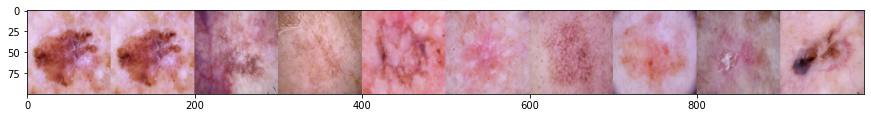

In [38]:
x = cv2.resize(numpy_horizontal,(1000, 100))
print(x.shape)
plt.figure(figsize=(15,8))
plt.imshow(x)

In [39]:
dir = "./Dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}
metadata['path'] = metadata['image_id'].map(image_path.get)

In [40]:
metadata.head(1)

,image_id,class,path
0,ISIC_0027419,2,./Dataset/Skin Cancer/Skin Cancer\ISIC_0027419...


In [41]:
len(metadata)

10015

# CNN MODEL (PYTORCH)

In [42]:
import torch
from torchvision import datasets, transforms
from PIL import Image


import albumentations as A
from albumentations.pytorch import ToTensor

import numpy as np


import torch.nn as nn
import torch.nn.functional as F

In [43]:

class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25




class Transforms:
    

    def __init__(self, train = True,  **transform_args):
        
        
        ## ARGS
        
        horizontal_flip_prob = transform_args['horizontal_flip_prob']
        vertical_flip_prob = transform_args['vertical_flip_prob']
        gaussian_blur_prob = transform_args['gaussian_blur_prob']
        rotate_degree = transform_args['rotate_degree']
        cutout = transform_args['cutout']
        cutout_height = transform_args['cutout_height']
        cutout_width = transform_args['cutout_width'] 
    
        
        mean=(0.5, 0.5, 0.5)
        std=(0.5, 0.5, 0.5)
        
        # Train phase transformations
         
        transforms_list = []
    
        if train:
#             if horizontal_flip_prob > 0:  # Horizontal Flip
#                 transforms_list += [A.HorizontalFlip(p=horizontal_flip_prob)]
#             if vertical_flip_prob > 0:  # Vertical Flip
#                 transforms_list += [A.VerticalFlip(p=vertical_flip_prob)]
#             if gaussian_blur_prob > 0:  # Patch Gaussian Augmentation
#                 transforms_list += [A.GaussianBlur(p=gaussian_blur_prob)]
#             if rotate_degree > 0:  # Rotate image
#                 transforms_list += [A.Rotate(limit=rotate_degree)]
#             if cutout > 0:  # CutOut
#                 transforms_list += [A.CoarseDropout(
#                     p=cutout, max_holes=1, fill_value=tuple([x * 255.0 for x in mean]),
#                     max_height=cutout_height, max_width=cutout_width, min_height=1, min_width=1
#                 )]
          pass
    
        transforms_list += [
            # normalize the data with mean and standard deviation to keep values in range [-1, 1]
            # since there are 3 channels for each image,
            # we have to specify mean and std for each channel
            A.Normalize(mean=mean, std=std, always_apply=True),
            
            # convert the data to torch.FloatTensor
            # with values within the range [0.0 ,1.0]
            ToTensor()
        ]
    
    
        self.transform =  A.Compose(transforms_list)    

    def __call__(self, image):
        """Process and image through the data transformation pipeline.

        Args:
            image: Image to process.
        
        Returns:
            Transformed image.
        """

        image = np.array(image)
        image = self.transform(image=image)['image']
        return image


In [44]:
train_met, test_met = train_test_split(metadata, test_size = 0.2, shuffle=True)

In [45]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform = None):
        self.df = data
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
#         print('INDEX : ', index)
        image_path = self.df[['path']].iloc[index].item()
#         print('PAth : |||', image_path)
        image = np.asarray(img.open(image_path).resize((224,224)))
        label = self.df[['class']].iloc[index].item()
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [46]:
train_met.head(2)

,image_id,class,path
2414,ISIC_0025677,6,./Dataset/Skin Cancer/Skin Cancer\ISIC_0025677...
54,ISIC_0026637,2,./Dataset/Skin Cancer/Skin Cancer\ISIC_0026637...


In [47]:
train_met[['path']].iloc[1].item()

'./Dataset/Skin Cancer/Skin Cancer\\ISIC_0026637.jpg'

In [48]:

transform_args = {}


transform_args['horizontal_flip_prob'] =  Args.horizontal_flip_prob
transform_args['vertical_flip_prob'] = Args.vertical_flip_prob
transform_args['gaussian_blur_prob'] = Args.gaussian_blur_prob
transform_args['rotate_degree'] = Args.rotate_degree
transform_args['cutout'] = 0.3
transform_args['cutout_height'] = 16
transform_args['cutout_width'] = 16


train_transforms = Transforms(train=True, **transform_args)
test_transforms = Transforms(train = False , **transform_args)  

train_dataset = CustomDataset(train_met, train_transforms )
test_dataset = CustomDataset(test_met, test_transforms)


image, label = train_dataset[0]

In [49]:
def get_device(force_cpu = True):
    
    if force_cpu:
        device = torch.device("cpu")
    
    else:
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

    return device

device = get_device()

In [50]:
if device.type == 'cpu':
    cuda = False
else:
    cuda = True

dataloader_args = dict(shuffle=True, batch_size=Args.train_batch_size, num_workers=Args.num_workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=Args.train_batch_size)


train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

## MODEL

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# from model2 import ResNet18
from torchsummary import summary

### In deep learning context, the Receptive Field (RF) is defined as the size of the region in the input that produces the feature. Basically, it is a measure of association of an output feature (of any layer) to the input region (patch)

In [52]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.01

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 224x224x3 | Output: 224x224x3 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 224x224x3 | Output: 224x224x3 | RF: 5x5

        self.convblock21 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18
        
        
        self.pool1 = nn.MaxPool2d(2, 2)  # Input: 224x224x3 | Output: 112x112x3 | RF: 6x6      jump = 1 -> 2
    
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 112x112x3  | Output:  112x112x8  | RF: 10x10    (+4)  
    
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 112x112x8    | Output:  112x112x8    | RF: 14x14  
    
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: 112x112x8    | Output:  112x112x8   | RF: 18x18   
    
        self.convblock51 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 112x112x8    | Output:  112x112x8   | RF: 18x18 
        
        
        self.pool2 = nn.MaxPool2d(2, 2)  # Input: 112x112x8 | Output: 56x56x5 | RF: 20x20       jump = 2 -> 4
    
    
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 56x56x5 | Output:  56x56x8 | RF: 28x28   (+8)
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 56x56x8 | Output:  56x56x16 | RF: 36x36
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: 56x56x16 | Output:  56x56x32 | RF: 44x44

        self.convblock81 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 56x56x32 | Output:  56x56x8 | RF: 44x44
        
        
        
        self.pool3 = nn.MaxPool2d(2, 2)  # Input: 56x56x16 | Output: 28x28x16 | RF: 48x48      jump = 4 -> 8

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x16 | Output: 28x28x16 | RF: 64x64         (+16)

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: Input: 28x28x16 | Output: 28x28x16 | RF: 80x80
        
        
        self.pool4 = nn.MaxPool2d(2, 2)  # Input: 56x56x16 | Output: 28x28x16 | RF: 88x88      jump = 8 -> 16
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: 14x14x32 | Output: 14x14x32 | RF: 120x120     (+32)

        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )  # Input: 14x14x32 | Output: 14x14x64 | RF: 152x152


        self.pool5 = nn.MaxPool2d(2, 2)  # Input: 28x28x64 | Output: 14x14x64 | RF: 168x168      jump = 16 -> 32        

        self.convblock13 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=7, kernel_size=1, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(7),
            nn.Dropout(dropout_rate)
        )  # Input: 7x7x64 | Output: 7x7x7 | RF: 232x232   (+64)

        
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock21(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock51(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock81(x)
        x = self.pool3(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.pool4(x)
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.pool5(x)
        x = self.convblock13(x)
        x = self.gap(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)
    

In [53]:

# model = ResNet18().to(device)
model = Net().to(device)
summary(model, input_size=( 3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
       BatchNorm2d-3          [-1, 8, 224, 224]              16
           Dropout-4          [-1, 8, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           1,168
              ReLU-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
           Dropout-8         [-1, 16, 224, 224]               0
            Conv2d-9          [-1, 8, 224, 224]             136
             ReLU-10          [-1, 8, 224, 224]               0
      BatchNorm2d-11          [-1, 8, 224, 224]              16
          Dropout-12          [-1, 8, 224, 224]               0
        MaxPool2d-13          [-1, 8, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [54]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  8 15:38:57 2021

@author: saina
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# from model import Net


def train(model, train_loader, criterion, optimizer, device, l1_factor =0,  **trackers):
      
    model.train()
    correct_classified = 0
    for batch_number , (x_train,y_train) in enumerate(train_loader):
        
        batch_number+=1
        
        x_train,y_train = x_train.to(device), y_train.to(device)

        # print(x_train.shape)
        pred = model.forward(x_train)

        # print(pred.shape)
        # print(y_train.shape)
        loss = criterion(pred,y_train)
        
        ## L1 LOSS
        if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss
        
        #pred.argmax(dim=1, keepdim=True)
        #PyTorch .eq() function to do this, which compares the values in two tensors and if they match, returns a 1. If they don’t match, it returns a 0:
        #correct += pred.eq(target.view_as(pred)).sum().item()
        predicted = torch.max(pred.data ,1)[1]
        correct_classified += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train_loader.dataset.data / train_loader.batch_size
        
        if batch_number%100 == 0:
            
            acc = round((correct_classified.item())/(batch_number*train_loader.batch_size),5)
            print(f'(TRAIN) batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
    
    acc = round((correct_classified.item())/len(train_loader.dataset),5)
    
    prev_acc = trackers['train_acc']
    trackers['train_acc'] = prev_acc.append(acc)
    
    prev_losses = trackers['train_losses']
    trackers['train_losses'] = prev_losses.append(loss.item())  






def test(model, test_loader, criterion, device, incorrect_samples, **trackers):
    
    test_losses = []
    
    model.eval()
    with torch.no_grad():
        
        correct_classified = 0
        for batch_number , (x_test,y_test) in enumerate(test_loader):
        
            x_test,y_test = x_test.to(device), y_test.to(device)
            pred = model.forward(x_test)
            loss = criterion(pred,y_test)
            test_losses.append(loss)
            
            correct_classified += (torch.max(pred,1)[1] == y_test).sum()
            
            ## INCORRECT PRED SAMPLES !
            output = pred.argmax(dim=1, keepdim=True)
            result = output.eq(y_test.view_as(output))
        
            if len(incorrect_samples) < 25:
                for i in range(test_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(output)[i],
                            'label': list(y_test.view_as(output))[i],
                            'image': list(x_test)[i]
                        }) 
    
        avg_loss = torch.mean(torch.tensor(test_losses))
        acc = round(correct_classified.item()/len(test_loader.dataset),5)
        
        prev_acc = trackers['test_acc']
        trackers['test_acc'] = prev_acc.append(acc)
        
        prev_losses = trackers['test_losses']
        trackers['test_losses'] = prev_losses.append(avg_loss.item())  
        
        print('(TEST) Correct_classified : ' , correct_classified.item() ,' of ' , len(test_loader.dataset))
        print(f'(TEST) Loss : {avg_loss:4.4} Acc : {acc:4.5}')
        print('\n','*'*60 , '\n')
        

     
        
     
        
        
def run_model(model, train_loader, test_loader, epochs, device, **regularization):
        
    # model = Net().to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    l2_factor = regularization['l2_factor']
    l1_factor = regularization['l1_factor']
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_factor)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
    
    ## TRACKERS
    train_losses = []
    train_acc = []
    train_trackers = {'train_acc':train_acc,'train_losses':train_losses}
    
    test_acc = []
    test_losses = []
    test_trackers = {'test_acc':test_acc,'test_losses':test_losses}
    
    incorrect_samples = []
    
    ## Model RUN!
    for epoch in range(1, epochs + 1):
        print(f'\nEpoch {epoch}:')
        train(model,train_loader, criterion, optimizer, device,l1_factor =l1_factor, **train_trackers)
        scheduler.step()
        test(model, test_loader, criterion, device, incorrect_samples, **test_trackers)
        
    return model,train_trackers,test_trackers,incorrect_samples

        

In [55]:
epochs = 20
regularization = {'l1_factor':0,'l2_factor':0}

model,train_trackers,test_trackers,incorrect_samples = run_model(model, train_loader, test_loader, epochs, device, **regularization)


Epoch 1:
(TRAIN) batch_number:  100 Loss : 0.9403 Acc : 0.60516
(TEST) Correct_classified :  1359  of  2003
(TEST) Loss : 0.95 Acc : 0.67848

 ************************************************************ 


Epoch 2:
(TRAIN) batch_number:  100 Loss : 0.8946 Acc :  0.7
(TEST) Correct_classified :  1393  of  2003
(TEST) Loss : 0.8573 Acc : 0.69546

 ************************************************************ 


Epoch 3:
(TRAIN) batch_number:  100 Loss : 0.7655 Acc : 0.71156
(TEST) Correct_classified :  1373  of  2003
(TEST) Loss : 0.8369 Acc : 0.68547

 ************************************************************ 


Epoch 4:
(TRAIN) batch_number:  100 Loss : 0.72 Acc : 0.71266
(TEST) Correct_classified :  1398  of  2003
(TEST) Loss : 0.8157 Acc : 0.69795

 ************************************************************ 


Epoch 5:
(TRAIN) batch_number:  100 Loss : 0.8204 Acc : 0.715
(TEST) Correct_classified :  1400  of  2003
(TEST) Loss : 0.8152 Acc : 0.69895

 ***************************

In [32]:
len(train_loader.dataset)

8012